In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt


from qutip.qip.device import Processor
from qutip_qip.device import CavityQEDModel
from qutip_qip.device import DispersiveCavityQED
from qutip.qip.compiler import CavityQEDCompiler
from qutip.qip.pulse import Pulse
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import cnot


#https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qip-randomized-benchmarking.ipynb

In [131]:
GHz = 10**9 #Hz
wq1 = 3.04 #* GHz # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 3.00 #* GHz # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 3  #* GHz # 5.19 * GHz * 2 * np.pi
g1 = 0.04 #* GHz  # 0.105 * GHz * 2 * np.pi
g2 = 0.04 #* GHz # g1
f = 0.5
amp = 0.1
# cavity dissapation rate
kappa = 0#0.033 * 2 * np.pi * GHz
# qubit dissapation rate
gamma1 = 0.0#0.00261 * GHz * 2* np.pi
gamma2 = gamma1
num_qubits = 1
num_c_levels = 2

In [116]:
# add operators and make circuit
T2 = 5
# tlist = np.arange(0.00, 20.2, 0.2) # later

In [129]:
# https://notebook.community/qutip/qutip-notebooks/examples/qip-noisy-device-simulator
# still don't know how to add detuning of qubits
processor = DispersiveCavityQED(num_qubits=num_qubits, num_levels = num_c_levels, sx=np.pi/2, w0=wc, g=10, t2=T2)
ham_idle = 2*np.pi * sigmaz()/2 * f
resonant_sx = 2*np.pi * sigmax () - ham_idle / (amp/2)
processor.add_drift(ham_idle, targets =0)
processor.add_control (resonant_sx , targets =0 , label ="sx0")

In [142]:
def ramsey(t,proc):
    qc = QubitCircuit(1)
    qc.add_gate("RX", 0 , arg_value =np.pi/2 )
    qc.add_gate("CPHASE", controls=0 , targets=0, arg_value = t )
    qc.add_gate("RX", 0 , arg_value =np.pi/2 )
    proc.load_circuit(qc)
    result = processor.run_state(init_state=basis(2,0), e_ops=sigmaz())
    return result.expect[0][-1]
 
for t in tlist:
    output = ramsey(t,processor)

NotImplementedError: Gate CPHASE cannot be resolved.

/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_2083/250727462.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


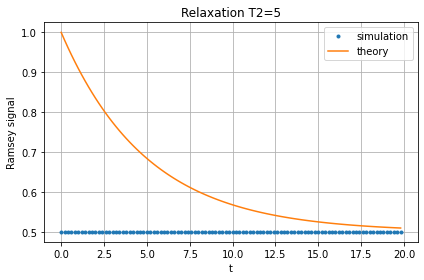

In [132]:
# to run a simulation with the processor, need to have a quantum circuit to evolve
#initial state to feed in, not sure what dims should be
psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 0))
psi0 = psi0.ptrace(0)
psi0 = tensor(basis(num_c_levels,0), basis(2,1))
# operator to get expectation value for, not sure what dims should be
a = tensor(destroy(num_c_levels), qeye(2))
Hadamard = tensor(snot(), identity(num_c_levels))
# op = Hadamard*a.dag()*a*Hadamard
sm = tensor(qeye(num_c_levels), destroy(2))
T2 = 5
tlist = np.arange(0.00, 20.2, 0.2)
coeff = np.ones(len(tlist))

# pass in expectation values to get
result = processor.run_state(psi0, tlist=tlist, e_ops=[a.dag()*a, Hadamard*a.dag()*a*Hadamard], options=Options(nsteps=50000))
 
fig, ax = plt.subplots()
# # detail about length of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[1][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./T2*tlist[:-1])*0.5 + 0.5, label="theory")
ax.set_xlabel("t")
ax.set_ylabel("Ramsey signal")
ax.legend()
ax.set_title("Relaxation T2=5")
ax.grid()
fig.tight_layout()
fig.show()

In [86]:
a = destroy(2)
Hadamard = snot()
plus_state =  basis([10,2],[0,0])
op = tensor(qeye(10), Hadamard*a.dag()*a*Hadamard)
T2 = 5
coeff = np.ones(len(tlist))
tlist = np.arange(0.00, 20.2, 0.2)
pulse = Pulse(sigmaz(), targets=0, coeff=coeff, tlist=tlist)

processor = DispersiveCavityQED(1,w0=wc,g=g1,t2=T2)
processor.add_pulse()
processor.pulses[0].coeff = np.ones(len(tlist))
processor.pulses[0].tlist = tlist
result = processor.run_state(
    plus_state, tlist=tlist) #, e_ops=op)
# qob(result).expect(op)

fig, ax = plt.subplots()
# detail about length of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect(op)[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./T2*tlist[:-1])*0.5 + 0.5, label="theory")
ax.set_xlabel("t")
ax.set_ylabel("Ramsey signal")
ax.legend()
ax.set_title("Relaxation T2=5")
ax.grid()
fig.tight_layout()
fig.show()

/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_2083/752181755.py:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  Hadamard = snot()
/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/qutip_qip/device/cavityqed.py:337: UserWarning: The rotating-wave approximation might not be valid.
  warnings.warn(


TypeError: Processor.add_pulse() missing 1 required positional argument: 'pulse'

/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_2083/3853142120.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


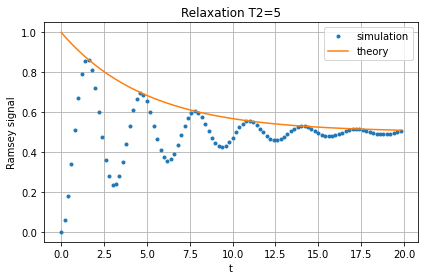

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import sigmaz, destroy, basis
from qutip.qip.device import Processor
from qutip.qip.operations import snot

a = destroy(2)
Hadamard = snot()
plus_state = (basis(2,1) + basis(2,0)).unit()
tlist = np.arange(0.00, 20.2, 0.2)

T2 = 5
processor = Processor(1, t2=T2)
processor.add_control(sigmaz())
processor.pulses[0].coeff = np.ones(len(tlist))
processor.pulses[0].tlist = tlist
result = processor.run_state(
    plus_state, e_ops=[Hadamard*a.dag()*a*Hadamard])

fig, ax = plt.subplots()
# detail about length of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./T2*tlist[:-1])*0.5 + 0.5, label="theory")
ax.set_xlabel("t")
ax.set_ylabel("Ramsey signal")
ax.legend()
ax.set_title("Relaxation T2=5")
ax.grid()
fig.tight_layout()
fig.show()